# [Computational Social Science] Project 4: Unsupervised Learning

**Name: Miray Salman** 

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# pip install tensorflow

In [2]:
import keras
print(keras.__version__)


2.15.0


In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

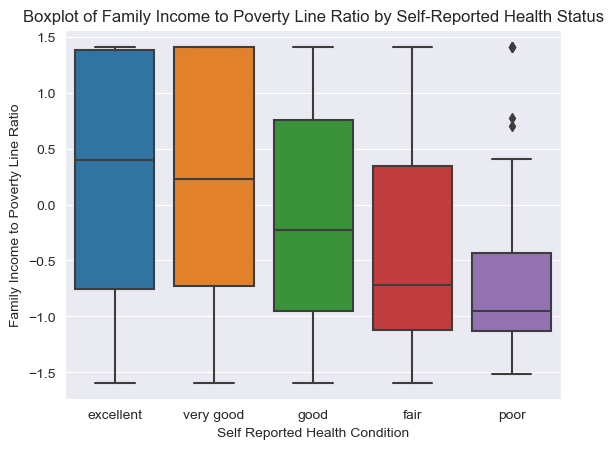

In [5]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

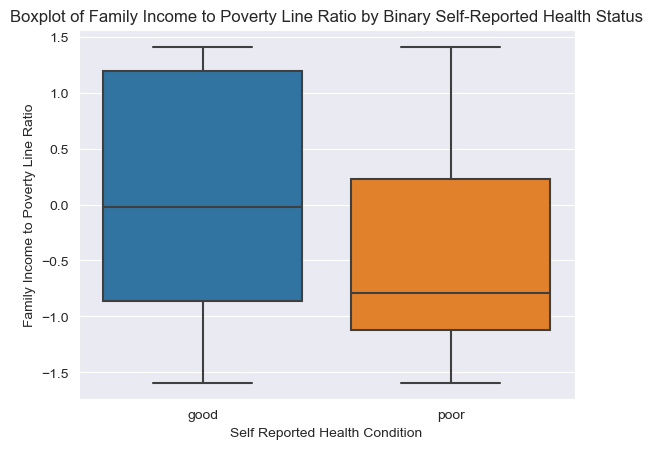

In [6]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

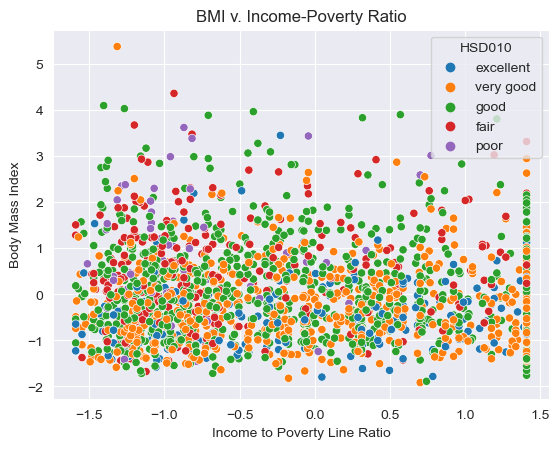

In [7]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [8]:
# Before dropping them, I'll create a copy of them to access later
hsd010 = nhanes_scaled['HSD010'].copy()
hsd010_binary = nhanes_scaled['HSD010_binary'].copy()

In [9]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

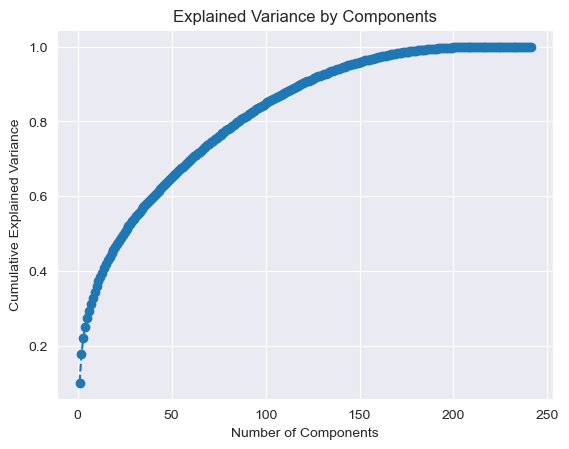

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(nhanes_scaled)

# Plotting the cumulative sum of explained variance
plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

The # of components I'll choose is ideally where the curve starts decreasing, before it flattens. Here, this is at 50-100 components (where the variance is ca. 65-80%). These components capture most of the variability in the data without needing to go to the full dimensionality. 

I want to explain 65% of the variance (as I value avoiding complexity a lot), which is why I am choseing to move forward with 50 components. 

### Barplot of Components

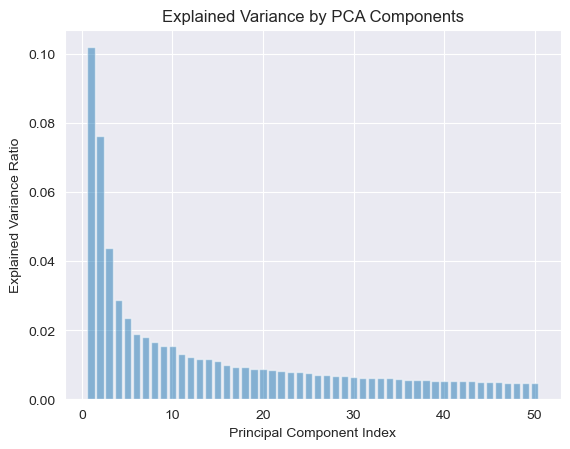

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(nhanes_scaled)

# Plotting the bar plot of explained variance for each component
plt.bar(range(1, 51), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.show()

#### Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.

### How many components will you use to fit a supervised learning model?

I'll answer this question in a longer version below for my personal future reference but provide you a short version. Feel free to only look at the short version for the grading. I just wanna use this in the future and have a more complex explanation for myself.

##### Short version: 
The bar plot suggests that the first few components account for most of the variance, with a steep drop after the first few. Hence, I'll use the first 30 components for my supervised model and value model accuracy over complexity reduction, as the added complexity seems manageable. 

##### long version: 
The graph shows the explained variance ratio for each of the first 50 principal components. 
The first few components seem to be explaining a significantly higher proportion of the variance than subsequent ones - The explained variance ratio strongly decreases after the first few components, suggesting they contain most of the important information.

Ideally, I would choose as few components as suggested by the significance in explaining variance share. In this case, the first few components have much higher explained variance ratios - which seem to be the first 5 components. However, I am concerned that choosing only the first 5 components might not be sufficient to explain a large enough proportion of the variance. My priority is as follows: I value the model's performance more than the managability of the added complexity, which is why I am choosing more components. Therefore, I am going to use the first 30 for my supervised model. This way, I am addressing the trade-off between the explained variance and the model complexity I'm willing to manage in favor of managing more complexity.

In order to confirm that I want to use exactly 30 components, I could calculate the cumulative explained variance up to the 30th component, and consider this value in addition to the requirements of the research question. This however would exceed the scope of this problemset for now, which is why I'm moving on limiting my decision-making process to a visual assessment of the appropriate nr. of components.  

### 2D Scatterplot of the first two components

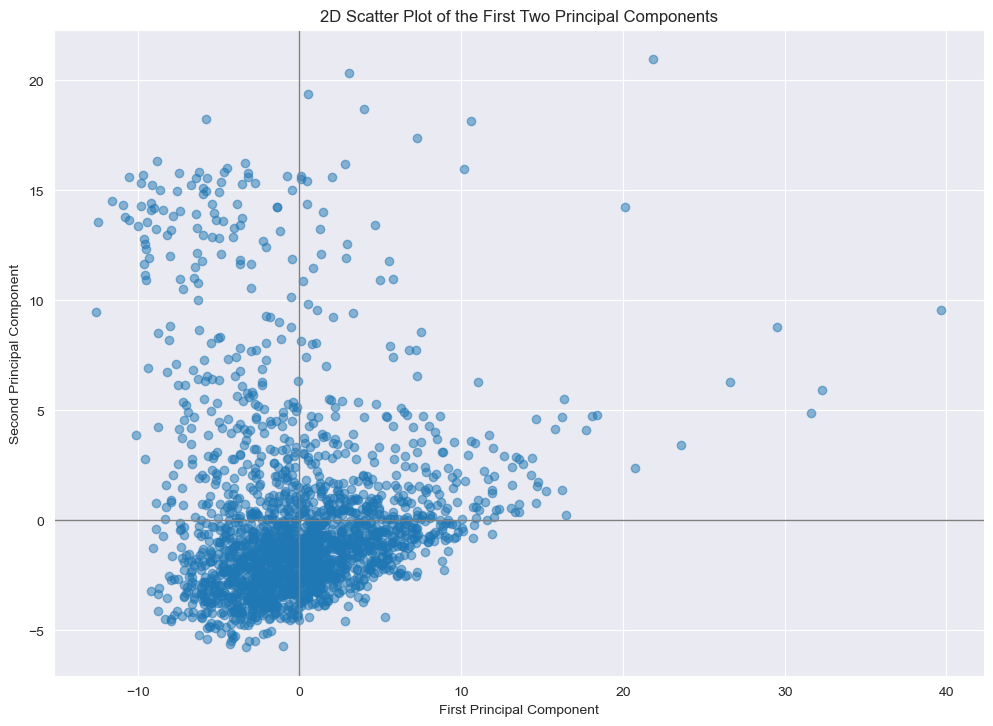

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(nhanes_scaled) 
plt.figure(figsize=(12, 8.4))        # I increased the size because there were so many data points. 
plt.scatter(components[:, 0], components[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D Scatter Plot of the First Two Principal Components')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)
plt.show()

##### Short version for consideration: 
The plot shows a dense cluster near the origin, suggesting similar values on the first 2 components for a large proportion of the data points. Only a few outliers extend towards the higher end of both components, meaning some extreme values or some of the variability may not be captured by the dense cluster.

##### Additional explanation for future reference:
Most of the dataset's variance is concentrated in a common area, indicating that many observations are similar with respect to the features captured by the first two principal components. The presence of outliers suggests there are some observations with unique characteristics that significantly differ from the main cluster. So, some exceptional cases or anomalies might me present in the dataset.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will use DBSCAN. DBSCAN can effectively distinguish between the densely packed data points and the outliers, which is beneficial given our dataset's characteristics. The algorithm does not force every point into a cluster, which is advantageous when dealing a dataset like this that includes noise and anomalies.

### Cluster nhanes

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Initialize DBSCAN with estimated parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(nhanes_scaled)

# The variable 'clusters' now holds the cluster assignments for each point in 'nhanes_scaled

In the case of DBSCAN, the number of clusters is not predetermined, unlike in methods such as K-Means, where you'd typically use the elbow method to determine the optimal number of clusters. Instead, DBSCAN automatically determines the number of clusters based on the dataset's density characteristics, controlled by the parameters eps (the radius to consider for neighborhood points) and min_samples (the minimum number of points required to form a dense region). The choice of these parameters is crucial and often requires experimentation; eps is usually selected based on domain knowledge or by examining a k-distance graph, while min_samples often depends on the dataset's dimensionality. In this process, the goal is to find a balance where the algorithm can effectively distinguish between true clusters and noise, thus revealing the inherent structure of the data.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

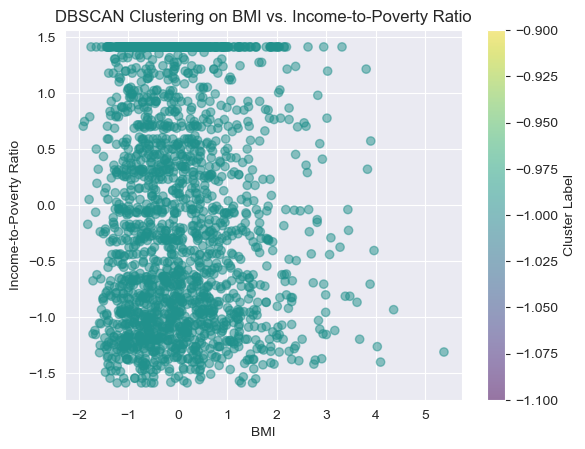

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN

plt.scatter(nhanes_scaled['BMXBMI'], nhanes_scaled['INDFMPIR'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Income-to-Poverty Ratio')
plt.title('DBSCAN Clustering on BMI vs. Income-to-Poverty Ratio')
plt.colorbar(label='Cluster Label')
plt.show()

## Your Answer Here

The scatter plot indicates that DBSCAN has primarily identified one dense cluster in the data, mostly centered around a narrow range of BMI values and a relatively higher Income-to-Poverty Ratio, while a few scattered points, likely classified as noise, are spread across a wider range of the BMI axis and lower Income-to-Poverty Ratios. This suggests that within the dataset, there's a significant grouping where BMI and Income-to-Poverty Ratio are closely related, with outliers that do not fit into this main cluster.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

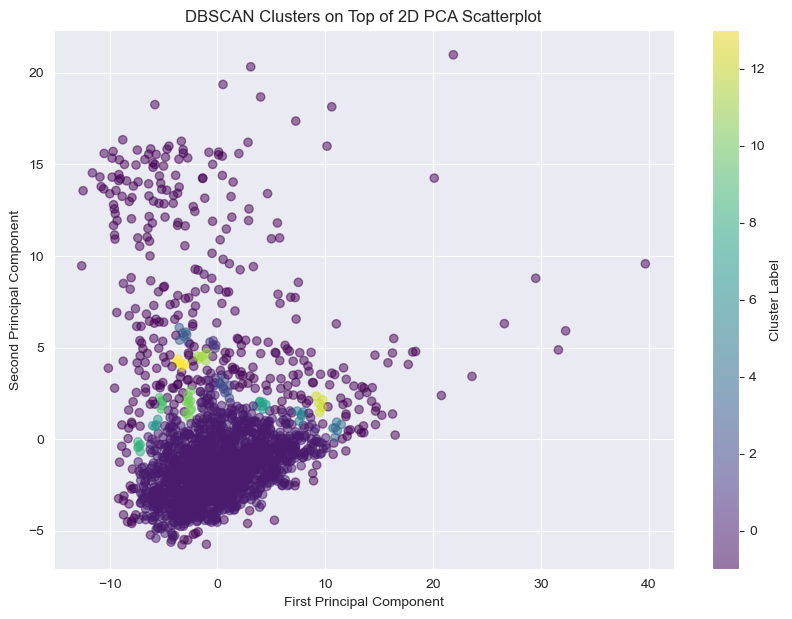

In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(nhanes_scaled)

# Apply DBSCAN to the PCA results
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune these parameters as needed
clusters = dbscan.fit_predict(pca_components)

# Plotting the clusters on top of the 2D PCA scatterplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('DBSCAN Clusters on Top of 2D PCA Scatterplot')
plt.colorbar(label='Cluster Label')
plt.show()

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [16]:
# Add the column back to the DataFrame
nhanes_scaled['HSD010_binary'] = hsd010_binary

In [17]:
print(nhanes_scaled.columns.tolist())

['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z', 'DRQSPREP', 'DR1STY', 'DRQSDIET', 'DR1TNUMF', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TRET', 'DR1TVARA', 'DR1TBCAR', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TFA', 'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TVC', 'DR1TVD', 'DR1TVK', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TMOIS', 'DR1TS040', 'DR1TS060', 'DR1TS080', 'DR1TS100', 'DR1TS120', 'DR1TS140', 'DR1TS160', 'DR1TS180', 'DR1TM161', 'DR1TM181', 'DR1TM201', 'DR1TP182', 'DR1TP183', 'DR1TP204', 'DR1.300', 'DR1TWS', 'DRD340', 'DRD360', 'PEASCST1', 'PEASCTM1', 'BPXPULS', 'BMDSTATS', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'MGDEXSTS', 'OHDEXSTS', 'OHDDESTS', 'OHX01TC', 'OHX02TC', 'OHX03TC', 'OHX04TC', 'OHX05

#### Miray notes:  
x = feature columns
y = outcome (a.k.a. target variable)

In [18]:
y = nhanes_scaled['HSD010_binary'].values 
feature_columns = nhanes_scaled.columns.drop(['HSD010_binary'])  # Drop target variable again
X = nhanes_scaled[feature_columns].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [19]:
num_classes = 2
# from keras.utils import np_utils
# convert class vectors to binary class matrices
# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)
# num_classes = y_test.shape[1]
# Since I'm getting an error telling me I can't import 'np_utils', I'm gonna use an alternative way to binarize:

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer() # Initialize label binarizer

# Fit and transform the training and test target arrays
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

num_classes = len(lb.classes_)

In [20]:
print(nhanes_scaled.shape[1])

242


In [21]:
model = Sequential()

model.add(
    Dense(2, input_dim= 241, kernel_initializer= 'uniform', activation= 'sigmoid')
)

model.add(
    Dense(2, kernel_initializer= 'normal', activation= 'relu')
)

## Add any additional layers you wish here

# model.compile(loss= ..., optimizer= ..., metrics=[...])

# model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

## Add Output Layer!!
model.add(Dense(1, activation='sigmoid'))

In [22]:
# compile the model with an optimizer, loss function, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Here are some things I tried to solve my problem when training the model: 

# print(type(X_train), type(X_test), type(y_train), type(y_test))

# print(X_train.dtype)
# print(y_train.dtype)

# mapping = {'good': 1, 'bad': 0, 'poor': 2}
# y_train_numerical = np.array([mapping[item] for item in y_train], dtype=np.float64)

# y_train = pd.to_numeric(y_train, errors='coerce')

In [24]:
# Next, I'd fit the model with the code below. Due to time constraints, I did not follow through with this.
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

In [25]:
# Then, I'd evaluate the model
# Then, I'd make adjustments to the model

### Neural Network on Principal Components

In [26]:
# Perform PCA on the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=50)

#y = nhanes_scaled['HSD010_binary'].values 
#feature_columns = nhanes_scaled.columns.drop(['HSD010_binary'])  # Drop target variable again
#X = nhanes_scaled[feature_columns].values  
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

X_pca = pca.fit_transform(X)  # assuming X is your original features

In [27]:
# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size = .25, random_state = 10)

In [28]:
# Adjust the input dimension in your model to match the number of PCA components:
model = Sequential()
model.add(Dense(2, input_dim=50, kernel_initializer='uniform', activation='sigmoid'))
model.add(Dense(2, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Neural Network on Principal Components + Cluster Membership

In [29]:
X_combined = np.column_stack((pca_components, clusters))

In [30]:
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=10)

In [31]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=242, input_dim=2 + 1, activation='sigmoid'))  # Adjust as needed
# Add more layers as required

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

#### Principal Component Analysis (PCA)
PCA helps reduce dimensionality. It transforms multi-dimensional datasets into principal components that retain most of the original data's variance by restructuring it into a lower-dimensional form while preserving the core information. Directions (principal components) in which the data has the highest variance are identified. These principal components represent the most significant features in the data. PCA outputs a set of principal components (new features) that are linear combinations of the original features.

PCA shines in linear relationships. It is useful for exploratory data analysis since it clarifies feature contribution by highlighting variation, facilitating the reduction of noise in the data. It brings out strong patterns. From an operational perspective, one of PCA’s advantages is that it helps reduce computational efforts, thus saving costs.  

PCA’s downsides include the potential loss of information due to dimensionality reduction, its limitedness to linear relationships, vulnerability to outliers, weaknesses in handling categorical data, lack of robustness to outliers and noise, and risk of overfitting.
Furthermore, a limitation of the PCA is that it inherently assumes that principal components with the highest variance are the most important ones, which is an over-generalization that the model inherently employs. 

#### Clustering
Through clustering, data points that are more similar to each other are grouped into the same cluster, differentiating it from the data in other clusters. Data points are assigned to clusters based on criteria (e.g. distance minimization between data points in the same cluster). Clustering models include K-means, hierarchical clustering, DBSCAN. Clustering outputs a set of labels assigning datapoints to specific clusters.
Similar to PCA, clustering too is useful for exploratory data analysis, as it identifies patterns in data. 


#### All in all
While PCA reduces dimensionality and features, retaining variance, clustering groups data into meaningful clusters.
PCA is a linear method where continuous data can be analyzed, while clustering is an unsupervised ML model that has the capacity to work with different datatypes.
PCA outputs transformed features (principal components), while clustering outputs labels that show the cluster membership of the data points.


## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?


#### When confronted with high dimensional datasets, using clustering and PCA complementarily can be advantageous. 
PCA might be used to reduce dimensionality prior to performing clustering. This would increase the efficiency and interpretability of the clustering. 

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

#### Results from unsupervised ML can serve as benchmarks for supervised ML models. 

A preliminary understanding of data structures and distributions with unsupervised ML helps us build more accurate supervised ML models. Aspects such as dimensionality reduction through PCA can improve the performance of supervised ML by eliminating redundant and less relevant features, focusing more significant ones. Unsupervised ML can uncover hidden patterns and reduce noise, improving the accuracy of supervised ML. It can help detect outliers and anomalies, enabling us to increase the robustness of the results of the supervised ML model that we are building. In large (big) datasets, unsupervised ML helps compress data into manageable sizes, making the use of more complex supervised ML models feasible. Clustering data through unsupervised ML, we can use these meaningful groups as features in our supervised ML model, thus improving the performance and interpretability of out supervised ML model. When there is scarcity in labelled data, it can be helpful to transfer features learned by an unsupervised ML model exploratively, to a related supervised ML model task.

Basically, unsupervised ML can help us explore data in a way that prepares us to prepare out supervised ML model. 
Conceptually, my understanding is that this is comparable to research in general, when conducting exploratory interviews prior to further data analysis, when there is a lack of research, e.g. due to novelty, on an issue. 
